# Example kMeans
In this notebook, we will go through two examples on how to use the class KMeans. We will first apply it on a toy example using our own generated data. Then, we will use it to cluster flowers in the iris dataset.


In [1]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from kMeans import KMeans

# Specific to Example II
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## Example I - Toy example with randomly generated data
In this example, we generate data from three different multivariate guassian distributions, all with the same covariance structure. Then, we perform the k-means algorithm using the class KMeans. Finally, we plot the predicted clusters together with the ground truth.

Converged to a solution after 6 iterations!


Text(0.5, 1.0, 'True clusters')

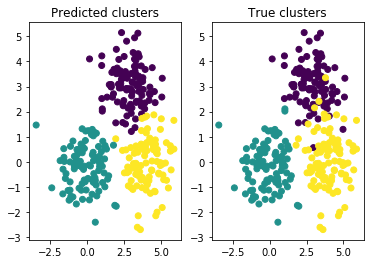

In [2]:
# Generate data from three multivariate (2-dimensional) guassian distributions.
n=100
mu = np.array([[3,3], [0,0], [4, 0]])
data = np.concatenate((np.random.randn(n,2) + mu[0], np.random.randn(n,2) + mu[1], np.random.randn(n,2) + mu[2]))

# We set the random seed to ensure reproducability
np.random.seed(123123123)

# Create an instance of the class KMeans by specicifying number of clusters (k=3) and the observations (X=data).
model = KMeans(k=3, X=data)

# We update the hyper-parameter distance function to the manhattan distance.
model.update_h_params({'dist_f' : 'L1_norm'})

# Run the k-means algorithm to find the clusters
_, y = model.fit()

# Visualize the clusters
plt.figure()

# Predicted clusters
plt.subplot(121)
plt.scatter(data[:,0], data[:,1], c=y)
plt.title("Predicted clusters")

# True clusters
plt.subplot(122)
plt.scatter(data[:,0], data[:,1], c=np.repeat([0,1,2], n))
plt.title("True clusters")

## Example II
In this example we use the class kMeans to cluster the flowers in the well known Iris-dataset. For convenience, we use scikit-learn to load the dataset. Further, we use a scree-plot (a plot of the within-sum-of-squares against the number of classes k) to choose number of clusters, i.e., a hyper-parameter tuning strategy. More specifically, we will use a thumbrule that says: look for the elbow in the scree-plot to choose the corresponding k. 

In [3]:
# Load the iris dataset using scikit-learn.
iris = datasets.load_iris()
features = iris['data']
feature_names = iris['feature_names']
labels = iris['target']
labels_names = iris['target_names']

# Load data into a pandas dataframe for convenience
data = pd.DataFrame(features, columns=feature_names)

# Initial data analysis
print(f"We have {data.shape[0]} observations on {data.shape[1]} features.")
data.head()

We have 150 observations on 4 features.


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


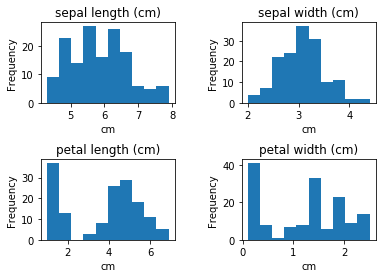

In [4]:
plt.figure()

# Create histogram of each feature
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(data.iloc[:,i])
    plt.ylabel("Frequency")
    plt.xlabel("cm")
    plt.title(data.columns[i])

# Increase space between subplots for better layout
plt.subplots_adjust(wspace=0.5, hspace=0.7)

I believe that in ordinary machine learning projects, a substantial portion of the work should go into the initial data analysis. However, we will let this complete our data analysis since this is not the goal of this example notebook. We have seen that we have four features measured on each flower. We see that we have no obviously wrong measurements, i.e., all lengths are positive and reasonable. 

We continue with clustering. Clustering belongs to unsupervised machine learning, which means that no labels are accessible. However, in this example we have labels available, but we will only use them in the end to compare our predicted clusters with the "ground truth". Next, we perform hyper-parameter tuning of the number of clusters k. We will do that by clustering the data for k=2, 3, ...,K where K is an arbitrarly choosen number. We choose K=10. For each k, we will perform 10 clusterings (train 10 models) with different starts, this is because the k-means is not guaranteed to find the optimal solution, only local optima. Hence, the final solution depends on the initial start. By doing 10 different starts we increase the probability of finding the optimal clustering. 

In [5]:
# Settings
nr_iterations = 1000
nr_starts = 10
K = 10

# Save the within-sum-of-squares so we can compare different k
WSS = np.zeros((1,K-1))
for k in range(2,K+1):
    # Print to follow progression
    print(f"Iteration {k-1} of {K-1} iterations.")
    
    wss = np.zeros((1, nr_starts))
    for start in range(nr_starts):
        # Create a KMeans object and fit it directly, we need to transform the dataframe to a numpy array
        wss_out, _ = KMeans(k=k, X=data.values, verbose=False, h_params={'n_iter' : nr_iterations}, random_state=np.random.randint(1000000)).fit()
        wss[0,start] = wss_out[-1]
        
    # Save lowest within-sum-of-squares for each k
    WSS[0,k-2] = np.nanmin(wss)

Iteration 1 of 9 iterations.
Iteration 2 of 9 iterations.
Iteration 3 of 9 iterations.
Iteration 4 of 9 iterations.
Iteration 5 of 9 iterations.
Iteration 6 of 9 iterations.
Iteration 7 of 9 iterations.
Iteration 8 of 9 iterations.
Iteration 9 of 9 iterations.


Text(0, 0.5, 'Within Sum of Squares')

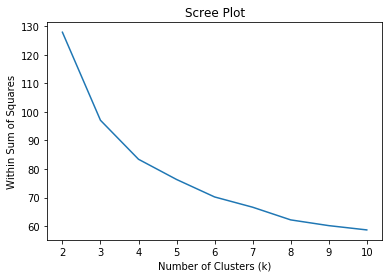

In [6]:
# Create scree plot
plt.figure()
plt.title("Scree Plot")
plt.plot(np.arange(K-1) + 2, WSS[0])
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Sum of Squares")

It is hard to find a distinct elbow in the above Scree Plot. If this was a pure machine learning problem, one should also use the average silhouette method to choose k. But since this is only an example and we have access to the real number of groups (which is 3), we choose k=3 so that we can evaluate the clusters. Next, we retrain 10 models with k=3 and plot the within sum of squares for each model to find the optimal one.

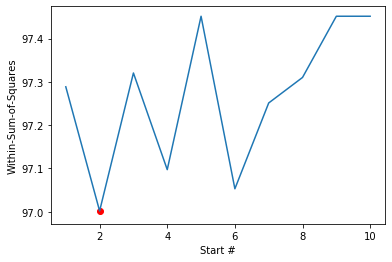

In [7]:
# Settings
nr_iterations = 1000
nr_starts = 10
k = 3
# Save the within-sum-of-squares so we can compare different k
wss = np.zeros((1, nr_starts))
predictions = []

# Set random seed to enable reproducibility
np.random.seed(27)

for start in range(nr_starts):
    # Create a KMeans object and fit it directly, we need to transform the dataframe to a numpy array
    wss_out, predictions_out = KMeans(k=k, X=data.values, verbose=False, h_params={'n_iter' : nr_iterations}).fit()
    wss[0,start] = wss_out[-1]
    predictions.append(predictions_out)

# Plotting the within-sum-of-squares and marking the minumum
plt.plot(np.arange(1, wss.shape[1]+1), wss[0])
plt.xlabel("Start #")
plt.ylabel("Within-Sum-of-Squares")
plt.scatter(np.argmin(wss)+1, wss[0][np.argmin(wss)], c="red")

We can see that the second model yielded the lowest wss as shown by the red dot. Now, we plot the predicted clusters versus the true clusters using the first two principal components.

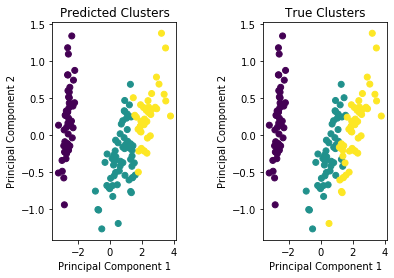

In [8]:
pca = PCA(n_components=2)
pca.fit(data)
pcs = pca.transform(data)

# Predicted clusters
plt.subplot(121)
plt.scatter(pcs[:,0], pcs[:,1], c=predictions[np.argmin(wss[0])])
plt.title("Predicted Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# True clusters
plt.subplot(122)
plt.scatter(pcs[:,0], pcs[:,1], c=labels)
plt.title("True Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.subplots_adjust(wspace=0.7)

We see that the predicted clusters corresponds quite well to the true clusters. Finally, we create a confusion matrix which we can use to calculate the overall accuracy, just as a measure of the performance of the k-means algorithm on the Iris-dataset. Once again, please remember, that in true unsupervised machine learning, we have no ground truth, so we cannot calculate any accuracy.

In [9]:
conf_m = confusion_matrix(labels, predictions[np.argmin(wss[0])])
print(conf_m)

[[50  0  0]
 [ 0 48  2]
 [ 0 14 36]]


In [10]:
print(f"We have an accuracy of {(50 + 48 + 36)/sum(sum(conf_m))*100:.2f}%")

We have an accuracy of 89.33%
